In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
# from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Dense, Input

In [24]:
parameters = ["wind_speed", "sunshine_duration",
            "pressure_air_site", "temperature_air_mean_200", "precipitation_height"]
# parameter=parameters[0]
# print(parameter)
# path="../data/weather/"+parameters[0]+"_2021.pkl"
# weather = pd.read_pickle(path)

def load_weatherdata(parameters):
    # means = pd.DataFrame()
    weather = pd.DataFrame()
    # weather_array = []
    # scaler_dict={}
    for parameter in parameters:
        path="../data/weather_all_stations/cleaned/"+parameter+".pkl"
        import_df = pd.read_pickle(path)
        index = import_df.index
        # columns = import_df.columns
        # column_list=columns.tolist()
        # scaled = pd.DataFrame(data = scaler.fit_transform(import_df), index=index, columns=columns)
        # means[parameter] = scaled.mean(axis=1)
        weather = pd.concat([weather, import_df], axis=1)
    # print(weather.head())
    import_shape=import_df.shape
    return weather, import_shape
# w2 = weather.melt(var_name='Column', value_name='Rescaled')

df, import_shape = load_weatherdata(parameters[:-1])
print(df.to_numpy().shape)
print(import_shape)
import_shape = (df.shape[0], int(df.shape[-1]/import_shape[-1]), import_shape[-1])
print(import_shape)
reshape_shape=(-1, *import_shape[1:])

(17544, 528)
(17544, 132)
(17544, 4, 132)


In [207]:
# Features that will be extracted from the EM data and their shorter handle
wx_params = {
    "temperature_air_mean_200": "temp",
    "wind_speed": "wind",
    "pressure_air_site": "press",
    # "precipitation_height": "precip",
    "sunshine_duration": "sun"
}

# Concatenate all weather parameters into one data frame
wx_dict = {}
for name, handle in wx_params.items():
    wx_dict[handle]=(pd.read_pickle("../data/weather/cleaned/"+name+".pkl"))

df = pd.concat(wx_dict.values(), axis=1, ignore_index=False, verify_integrity=True, keys=wx_dict.keys())
df.head()

temp                                          \
                            00183   00701   00856   00953   00963   01443   
date                                                                        
2020-01-01 00:00:00+00:00  277.35  276.75  270.95  273.55  271.95  271.45   
2020-01-01 01:00:00+00:00  277.55  277.15  270.75  273.75  272.35  271.65   
2020-01-01 02:00:00+00:00  277.15  275.55  269.75  272.65  272.95  271.75   
2020-01-01 03:00:00+00:00  277.45  274.85  271.55  272.05  272.75  271.35   
2020-01-01 04:00:00+00:00  277.45  274.25  270.85  272.65  272.15  271.35   

                                                           ...          sun  \
                            01605   01694   03032   03231  ...        00856   
date                                                       ...                
2020-01-01 00:00:00+00:00  275.45  274.65  279.25  271.25  ...  1083.274729   
2020-01-01 01:00:00+00:00  274.15  274.25  279.05  269.95  ...  1083.274729   
2020-01-01 02:00:00+00:00  274.45  273.15  279.15  270.15  ...  1083.274729   
2020-01-01 03:00:00+00:00  273.85  273.35  279.35  269.45  ...     0.000000   
2020-01-01 04:00:00+00:00  275.05  273.35  279.35  269.25  ...     0.000000   

                                                                           \
                                00953      00963        01443       01605   
date                                                                        
2020-01-01 00:00:00+00:00  940.243235  862.78691  1049.052342  924.726291   
2020-01-01 01:00:00+00:00  940.243235  862.78691  1049.052342  924.726291   
2020-01-01 02:00:00+00:00  940.243235  862.78691  1049.052342  924.726291   
2020-01-01 03:00:00+00:00    0.000000    0.00000     0.000000    0.000000   
2020-01-01 04:00:00+00:00    0.000000    0.00000     0.000000    0.000000   

                                                                           \
                                01694       03032       03231       04104   
date                                                                        
2020-01-01 00:00:00+00:00  970.492656  945.035348  874.640783  921.721343   
2020-01-01 01:00:00+00:00  970.492656  945.035348  874.640783  921.721343   
2020-01-01 02:00:00+00:00  970.492656  945.035348  874.640783  921.721343   
2020-01-01 03:00:00+00:00    0.000000    0.000000    0.000000    0.000000   
2020-01-01 04:00:00+00:00    0.000000    0.000000    0.000000    0.000000   

                                        
                                 04177  
date                                    
2020-01-01 00:00:00+00:00  1027.347777  
2020-01-01 01:00:00+00:00  1027.347777  
2020-01-01 02:00:00+00:00  1027.347777  
2020-01-01 03:00:00+00:00     0.000000  
2020-01-01 04:00:00+00:00     0.000000  

[5 rows x 48 columns]

In [208]:
df.columns.levshape

(4, 12)

In [209]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
df_train = df[0:int(n*0.7)]
df_val = df[int(n*0.7):int(n*0.9)]
df_test = df[int(n*0.9):]


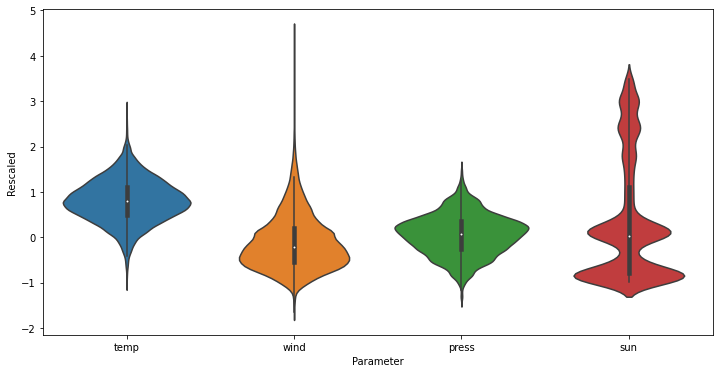

In [210]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
scaler = RobustScaler()

scaler.fit(df_train)
# scale all sets according to train set, preserve data frames
df_train = pd.DataFrame(scaler.transform(df_train),
                        columns=df.columns, index=df_train.index).clip(lower=-3)
df_val = pd.DataFrame(scaler.transform(df_val),
                        columns=df.columns, index=df_val.index)
df_test = pd.DataFrame(scaler.transform(df_test),
                        columns=df.columns, index=df_test.index)
plt.figure(figsize=(12, 6))

ax = sns.violinplot(x="Parameter", y="Rescaled", data=df_val.melt(var_name='Parameter', value_name='Rescaled'))
# _ = ax.set_xticklabels(df.keys(), rotation=90)

In [212]:
X_train = df_train.to_numpy().reshape(-1, *df.columns.levshape)
X_val = df_val.to_numpy().reshape(-1, *df.columns.levshape)
X_test = df_test.to_numpy().reshape(-1, *df.columns.levshape)
input_dim=X_train.shape[1:]

# this fixes the latent space dimension, feel free to play around with
# the values for your own experiments, but leave it at 2 for the assignment
latent_dim = 10
print(input_dim)
print(X_train.shape)
print(df_train.shape)

(4, 12)
(12280, 4, 12)
(12280, 48)


In [213]:
from tensorflow.keras.backend import clear_session

clear_session()

# this is very similar to what we've done before. First, instantiate a
# "Sequential()" model in a variable called "shallow_ae". Then, add a
# "Dense()" layer to shallow_ae with latent_dim neurons, an appropriate "input_shape"
# and activation "relu". Afterwards, add another Dense layer with an appropriate
# number of neurons to be able to construct an MNIST image and "sigmoid"
# activation.
# YOUR CODE HERE
shallow_ae=Sequential()
shallow_ae.add(Dense(latent_dim, input_shape=input_dim,  activation='tanh'))
shallow_ae.add(layers.Flatten())
shallow_ae.add(Dense(X_train.shape[1]*X_train.shape[2], activation='tanh'))
shallow_ae.add(layers.Reshape(df.columns.levshape))

shallow_ae.summary()

# plot_model(shallow_ae)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4, 10)             130       
                                                                 
 flatten (Flatten)           (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 48)                1968      
                                                                 
 reshape (Reshape)           (None, 4, 12)             0         
                                                                 
Total params: 2,098
Trainable params: 2,098
Non-trainable params: 0
_________________________________________________________________


In [214]:
# create an input layer with the appropriate shape
input_img = Input(shape=(*input_dim,))
input_lat = Input(shape=(latent_dim,))

# extract the first shallow_ae layer
encoder_layer = shallow_ae.layers[0]
decoder_layer = shallow_ae.layers[-1]

# make them addressable models
shallow_encoder = Model(input_img, encoder_layer(input_img))
shallow_decoder = Model(input_lat, decoder_layer(input_lat))

shallow_encoder.summary()
shallow_decoder.summary()

# #plot_model(shallow_encoder)
# plot_model(shallow_decoder)

ValueError: Exception encountered when calling layer "reshape" (type Reshape).

total size of new array must be unchanged, input_shape = [10], output_shape = [4, 12]

Call arguments received:
  • inputs=tf.Tensor(shape=(None, 10), dtype=float32)

In [215]:
shallow_ae.compile(optimizer="adam", loss="mse")
history=shallow_ae.fit(X_train, X_train, epochs=15, batch_size=256, shuffle=True, validation_data=(X_val, X_val))

Epoch 1/15
48/48 [==============================] - 1s 6ms/step - loss: 0.8391 - val_loss: 0.6443
Epoch 2/15
48/48 [==============================] - 0s 3ms/step - loss: 0.5598 - val_loss: 0.4691
Epoch 3/15
48/48 [==============================] - 0s 3ms/step - loss: 0.4364 - val_loss: 0.3985
Epoch 4/15
48/48 [==============================] - 0s 5ms/step - loss: 0.3870 - val_loss: 0.3701
Epoch 5/15
48/48 [==============================] - 0s 5ms/step - loss: 0.3638 - val_loss: 0.3538
Epoch 6/15
48/48 [==============================] - 0s 3ms/step - loss: 0.3481 - val_loss: 0.3408
Epoch 7/15
48/48 [==============================] - 0s 3ms/step - loss: 0.3350 - val_loss: 0.3291
Epoch 8/15
48/48 [==============================] - 0s 4ms/step - loss: 0.3234 - val_loss: 0.3188
Epoch 9/15
48/48 [==============================] - 0s 3ms/step - loss: 0.3132 - val_loss: 0.3094
Epoch 10/15
48/48 [==============================] - 0s 3ms/step - loss: 0.3041 - val_loss: 0.3009
Epoch 11/15
48/48 [

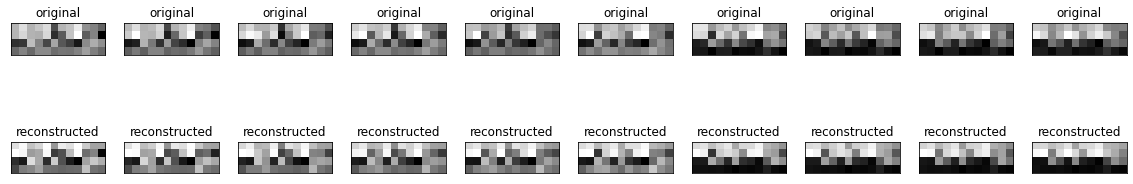

In [216]:
# encoded_imgs = shallow_encoder(df_test).numpy()
# decoded_imgs = shallow_decoder(encoded_imgs).numpy()
reconstructed_imgs = shallow_ae.predict(X_test).reshape(-1, *df.columns.levshape)
n = 10
offset=0
plt.figure(figsize=(20, 4))

for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i+offset])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(reconstructed_imgs[i+offset])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


In [221]:
from tensorflow.keras.utils import plot_model
plot_model(shallow_ae, to_file='../models/shallow_ae.png')


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [222]:
shallow_ae.save("../models/autoencoder")

INFO:tensorflow:Assets written to: ../models/autoencoder\assets


In [224]:
loaded_model = tf.keras.models.load_model("../models/autoencoder")

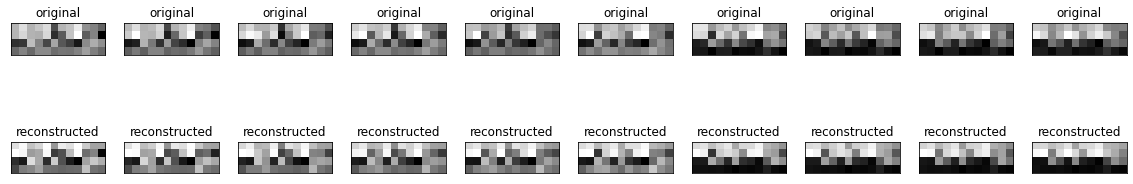

In [225]:
# encoded_imgs = shallow_encoder(df_test).numpy()
# decoded_imgs = shallow_decoder(encoded_imgs).numpy()
reconstructed_imgs = loaded_model.predict(X_test).reshape(-1, *df.columns.levshape)
n = 10
offset=0
plt.figure(figsize=(20, 4))

for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i+offset])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(reconstructed_imgs[i+offset])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

### Approach from online tutorial:

In [114]:
print(X_train.shape, X_val.shape, X_test.shape)

(12280, 4, 12) (3509, 4, 12) (1755, 4, 12)


In [121]:
latent_dim = 10

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim*2, activation='tanh'),
      layers.Dense(latent_dim, activation='tanh'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(X_train.shape[1]*X_train.shape[2]/2, activation='tanh'),
      layers.Dense(X_train.shape[1]*X_train.shape[2], activation='tanh'),
      layers.Reshape((X_train.shape[1], X_train.shape[2]))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


In [122]:
clear_session()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
autoencoder = Autoencoder(latent_dim)
autoencoder.compile(optimizer=optimizer, loss="mae")
autoencoder.build(input_shape=X_train.shape)
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (12280, 10)               1190      
                                                                 
 sequential_1 (Sequential)   (12280, 4, 12)            1464      
                                                                 
Total params: 2,654
Trainable params: 2,654
Non-trainable params: 0
_________________________________________________________________


In [123]:
autoencoder.fit(X_train, X_train,
                epochs=20,
                shuffle=True,
                validation_data=(X_val, X_val))

Epoch 1/20
384/384 [==============================] - 1s 2ms/step - loss: 0.3593 - val_loss: 0.3207
Epoch 2/20
384/384 [==============================] - 1s 2ms/step - loss: 0.3124 - val_loss: 0.3065
Epoch 3/20
384/384 [==============================] - 1s 2ms/step - loss: 0.3065 - val_loss: 0.3067
Epoch 4/20
384/384 [==============================] - 1s 2ms/step - loss: 0.3031 - val_loss: 0.3132
Epoch 5/20
384/384 [==============================] - 1s 2ms/step - loss: 0.3020 - val_loss: 0.3041
Epoch 6/20
384/384 [==============================] - 1s 2ms/step - loss: 0.3012 - val_loss: 0.2927
Epoch 7/20
384/384 [==============================] - 1s 2ms/step - loss: 0.2990 - val_loss: 0.2973
Epoch 8/20
384/384 [==============================] - 1s 2ms/step - loss: 0.2963 - val_loss: 0.2958
Epoch 9/20
384/384 [==============================] - 1s 2ms/step - loss: 0.2946 - val_loss: 0.2894
Epoch 10/20
384/384 [==============================] - 1s 2ms/step - loss: 0.2922 - val_loss: 0.2877

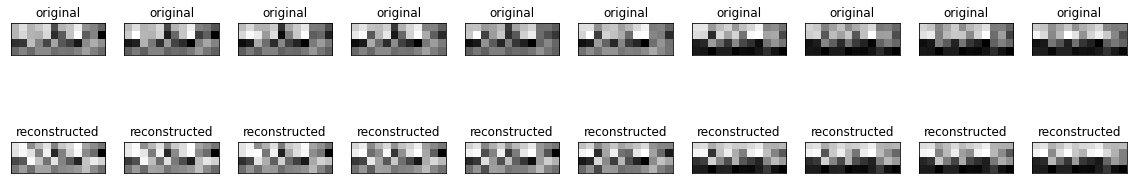

In [124]:
encoded_imgs = autoencoder.encoder(X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()
n = 10
offset=0
plt.figure(figsize=(20, 4))

for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i+offset])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i+offset])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()
